# Neural Style Transfer (NST)

## Overview
Neural Style Transfer (NST) is an interesting optimization techniques in deep learning. It merges two images, namely: a **"content" image (C)** and a **"style" image (S)**, to create a **"generated" image (G)**. The generated image G combines the "content" of the image C with the "style" of image S. 

Based on Neural Style Transfer, an algorithm created by [Gatys et al. (2015).](https://arxiv.org/abs/1508.06576)

<img src="images/image_gatys.png" style="width:750px;height:200px;">

## Matching generated image (G) to 'Content' Image (C)

To get the most visually pleasing results we'll choose a layer in the middle of the network - neither too shallow nor too deep. This ensures that the network detects both higher-level and lower-level features.
* The shallower layers of a ConvNet tend to detect lower-level features such as edges and simple textures.
* The deeper layers tend to detect higher-level features such as more complex textures and object classes. 

**Cost Function:**
$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

* $a^{(C)}$ and $a^{(G)}$ are the 3D volumes corresponding to a hidden layer's activations. 
* $n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer and appear in a normalization term in the cost. 
* Easier to compute the cost $J_{content}(C,G)$, by changing from 3D volumes to 2D matrix.


## Matching generated image (G) to 'Style' Image (S)

Image style is characterized through correlation / sumproduct of values across different channels of a layer.This style matrix is also called a **"Gram matrix"**. (~similar to how a variance-covariance matrix would look). For a smoother feel, we'll select style from multiple layers.

* Diagonal elements measure how "active" a filter $i$ is. E.g., suppose filter $i$ is detecting vertical textures in the image. Then $G_{(gram)ii}$ measures how common vertical textures are in the image as a whole. If $G_{(gram)ii}$ is large, it means that image has a lot of vertical texture.

<img src="images/NST_GM.png" style="width:500px;height:200px;">

**Cost Function:**

* For a single hidden layer$a^{[l]}$, cost is defined as: 

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$

* For multiple layers, it becomes:
$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where $\lambda^{[l]}$ values are hyper-parameters.

## Objective Function
$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

## Helper Functions
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

from PIL import Image
import tensorflow as tf

img_size = 400

In [20]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost
    Arguments:
    a_C -- tensor (1, n_H, n_W, n_C), hidden layer activations representing content of image C 
    a_G -- tensor (1, n_H, n_W, n_C), hidden layer activations representing content of image G
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    # Content layer related output is in the last index
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
   
    # Reshape the images from (n_H * n_W, n_C) to (n_C, n_H * n_W)
    a_C_unrolled = tf.transpose(tf.reshape(a_C, (-1, n_C)), perm=[1,0])
    a_G_unrolled = tf.transpose(tf.reshape(a_G, (-1, n_C)), perm=[1,0])
    
    J_content = (1/(4*n_H*n_W*n_C))*tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))
    
    return J_content

In [5]:
def gram_matrix(A):
    """
    A -- matrix of shape (n_C, n_H*n_W)
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """  
    GA = tf.linalg.matmul(A, tf.transpose(A))
    return GA

In [6]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images from (n_H * n_W, n_C) to (n_C, n_H * n_W)
    a_S = tf.transpose(tf.reshape(a_S, (-1, n_C)), perm=[1,0])
    a_G = tf.transpose(tf.reshape(a_G, (-1, n_C)), perm=[1,0])

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    J_style_layer = 1/(2*n_C*n_H*n_W)**2 * tf.reduce_sum(tf.square(tf.subtract(GS, GG)))
    
    return J_style_layer

In [7]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize style cost
    J_style = 0

    # The last element is the o/p for content layer, which is not used for style.
    a_S = style_image_output[:-1]
    a_G = generated_image_output[:-1]

    for i, weight in enumerate(STYLE_LAYERS):  
        
        J_style += weight[1] * compute_layer_style_cost(a_S[i], a_G[i])

    return J_style

In [8]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):  
    J = alpha*J_content + beta*J_style
    return J

## Load Images
### Content Image

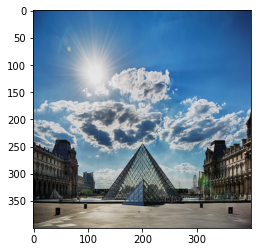

In [9]:
content_image = np.array(Image.open("data/neural_style_transfer/louvre.jpg").resize((img_size, img_size)))
content_image = tf.reshape(content_image, ((1,) + content_image.shape))
content_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))

imshow(content_image[0]);

### Style Image

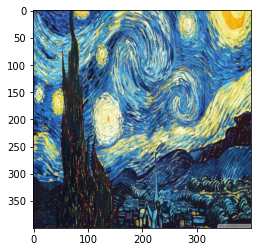

In [10]:
style_image = np.array(Image.open("data/neural_style_transfer/van_gogh.jpg").resize((img_size, img_size)))
# monet_800600

style_image = tf.reshape(style_image, ((1,) + style_image.shape))
style_image = tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))

imshow(style_image[0]);

### Generated Image (starting point)
* This can be white noise image (as illustrated in the paper)
* However, here we initialize it to be closer to content image with noise, for faster convergence

(1, 400, 400, 3)


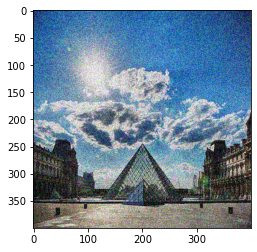

In [11]:
generated_image = content_image
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image[0]);

## VGG Model

VGG network from the [original NST paper](https://arxiv.org/abs/1508.06576) published by the Visual Geometry Group at University of Oxford in 2014. Specifically, we'll use VGG-19, a 19-layer version of the VGG network. 

This model has already been trained on the very large ImageNet database, and has learned to recognize a variety of low level features (at the shallower layers) and high level features (at the deeper layers). 

In [12]:
tf.random.set_seed(272)
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='pretrainedmodel/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')
vgg.trainable = False
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 400, 400, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 400, 400, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 200, 200, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 200, 200, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 200, 200, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 100, 100, 128)     0     

### Selecting intermediate layers for 'Content' & 'Style'

In [13]:
# Style Layer
CONTENT_LAYER = [('block5_conv4', 1)]

# Style layers
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

In [14]:
def get_layer_outputs(model, layer_names):
    """ Creates a'model' with output = intermediate output values"""
    
    outputs = [model.get_layer(layer[0]).output for layer in layer_names]
    intermediate_model = tf.keras.Model([model.input], outputs)
    
    return intermediate_model

In [15]:
vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + CONTENT_LAYER)

## Training

In [16]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    tensor = tensor[0]
    return Image.fromarray(tensor)

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

def train_step(generated_image):
    with tf.GradientTape() as tape:
        a_G = vgg_model_outputs(generated_image)        
        J_style = compute_style_cost(a_S, a_G, STYLE_LAYERS)
        J_content = compute_content_cost(a_C, a_G)
        J = total_cost(J_content, J_style)
        
    grad = tape.gradient(J, generated_image)
    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    return J

In [18]:
a_C = vgg_model_outputs(content_image)
a_S = vgg_model_outputs(style_image)

Epoch  0


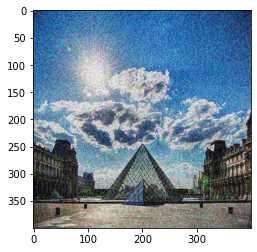

Epoch  250


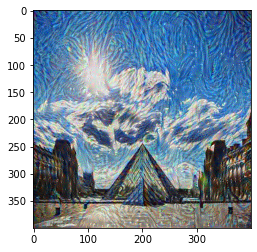

Epoch  500


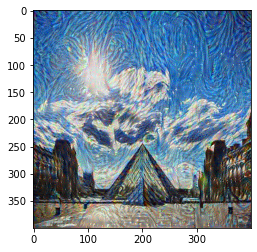

Epoch  750


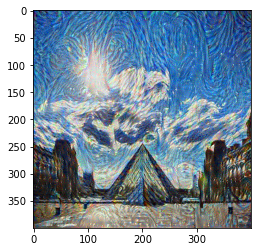

Epoch  1000


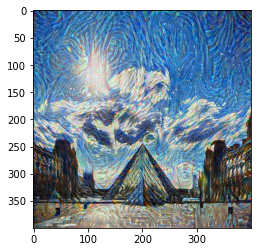

Epoch  1250


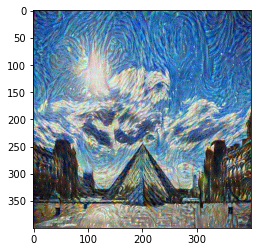

Epoch  1500


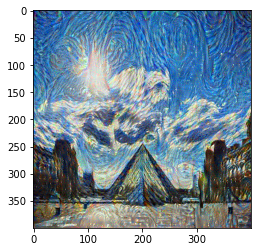

Epoch  1750


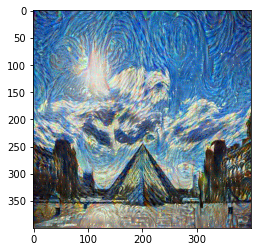

Epoch  2000


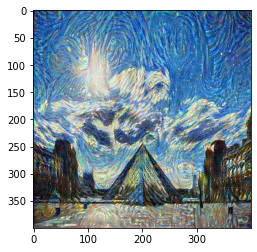

Epoch  2250


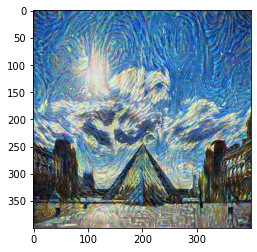

Epoch  2500


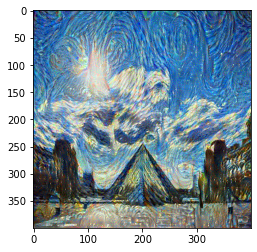

In [19]:
generated_image = tf.Variable(generated_image)
epochs = 2501

for i in range(epochs):
    train_step(generated_image)
    if i % 250 == 0:
        print("Epoch ", i)
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"output/NST_{i}.jpg")
        plt.show() 